# Customer Churn Data Analysis - EagleSouth

## Libraries

In [43]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.feature_selection import SelectFromModel
import matplotlib.cm as cm

# Data files

We will import the data into pandas dataframes and drop any NA values they may have.

In [2]:
df_test = pd.read_csv("Test sample No Label.csv").dropna()
df_train = pd.read_csv("Train Set.csv").dropna()

I noticed that the ''TotalCharges'' variable has some empty data. Therefore, I am deleting the rows in which this variable is empty.

In [3]:
nan_value = float("NaN")
df_train.replace(' ', nan_value, inplace=True)
df_train.dropna(subset = ["TotalCharges"], inplace=True)
df_train.reset_index(drop=True, inplace=True)

# Data exploration and modeling


Let's explore the datasets. First, we will look at the shape of each one to see how many columns and rows they have.

In [4]:
print('The shape of the test dataset is: '+str(df_test.shape))
print('The shape of the train dataset is: '+str(df_train.shape))

The shape of the test dataset is: (900, 20)
The shape of the train dataset is: (6132, 21)


We can also see some statistics of the numerical variables of each dataset.

In [5]:
df_test.describe()

,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,900.000000,900.000000,900.000000,900.000000,900.000000
mean,8449.500000,0.153333,33.310000,65.940833,2353.882222
std,259.951919,0.360509,25.237217,29.495604,2296.744079
min,8000.000000,0.000000,1.000000,18.850000,18.850000
25%,8224.750000,0.000000,8.000000,43.975000,374.837500
50%,8449.500000,0.000000,31.000000,72.975000,1434.350000
75%,8674.250000,0.000000,57.250000,89.812500,3887.600000
max,8899.000000,1.000000,72.000000,118.750000,8672.450000


In [6]:
df_train.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,6132.000000,6132.000000,6132.000000
mean,0.163731,32.291422,64.630504
std,0.370062,24.441443,30.170374
min,0.000000,1.000000,18.250000
25%,0.000000,9.000000,35.150000
50%,0.000000,29.000000,70.200000
75%,0.000000,55.000000,89.900000
max,1.000000,72.000000,118.650000


We can see that, for example, in the train dataset, the mean tenure (number of months the customer has stayed with the company) is about 32 months.

We can also observe that the variable ''TotalCharges'' was not identified as numeric in the train dataset. Let's convert it to numeric.

In [7]:
df_train["TotalCharges"] = pd.to_numeric(df_train["TotalCharges"])

We verify that ''TotalCharges'' is no longer identified as an object. 

In [8]:
df_train.select_dtypes(['object']).columns

Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

Now, let's see the categorial variables: 

In [9]:
categoric_df = df_train.select_dtypes(['object'])
print('Features and their unique values:\n')
for column in categoric_df:
  # se usa nunique y unique
  print(f'Feature: {column}, {df_train[column].nunique()} unique values:')
  print(df_train[column].unique())

  print()

Features and their unique values:

Feature: customerID, 6132 unique values:
['A00001' 'A00002' 'A00003' ... 'A06141' 'A06142' 'A06143']

Feature: gender, 2 unique values:
['Male' 'Female']

Feature: Partner, 2 unique values:
['Yes' 'No']

Feature: Dependents, 2 unique values:
['Yes' 'No']

Feature: PhoneService, 2 unique values:
['Yes' 'No']

Feature: MultipleLines, 3 unique values:
['Yes' 'No' 'No phone service']

Feature: InternetService, 3 unique values:
['DSL' 'No' 'Fiber optic']

Feature: OnlineSecurity, 3 unique values:
['No' 'No internet service' 'Yes']

Feature: OnlineBackup, 3 unique values:
['Yes' 'No internet service' 'No']

Feature: DeviceProtection, 3 unique values:
['Yes' 'No internet service' 'No']

Feature: TechSupport, 3 unique values:
['No' 'No internet service' 'Yes']

Feature: StreamingTV, 3 unique values:
['Yes' 'No internet service' 'No']

Feature: StreamingMovies, 3 unique values:
['Yes' 'No internet service' 'No']

Feature: Contract, 3 unique values:
['Two year'

Now, let's look at a correlogram to see the correlation between the numerical variables.

Train dataset Correlogram


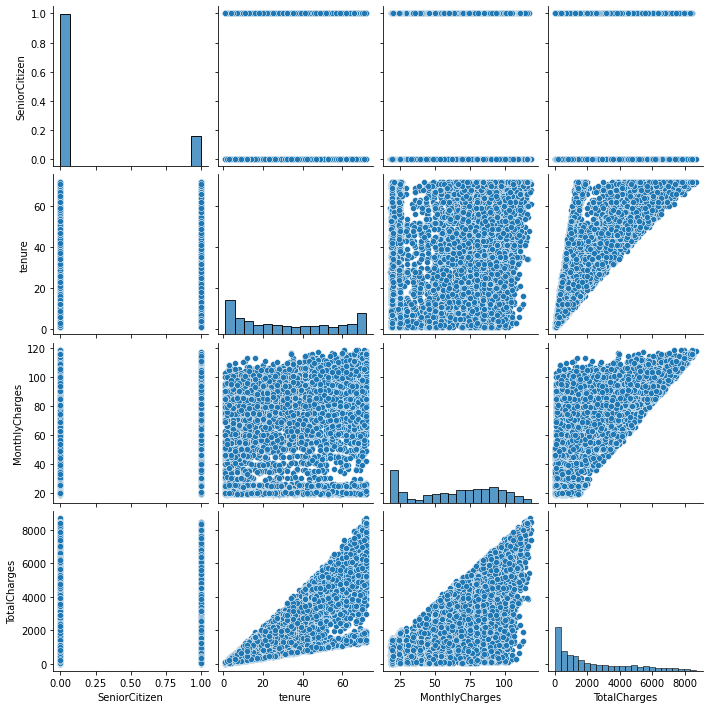

In [10]:
print('Train dataset Correlogram')
sns.pairplot(df_train, kind="scatter")
plt.show()

Test dataset Correlogram


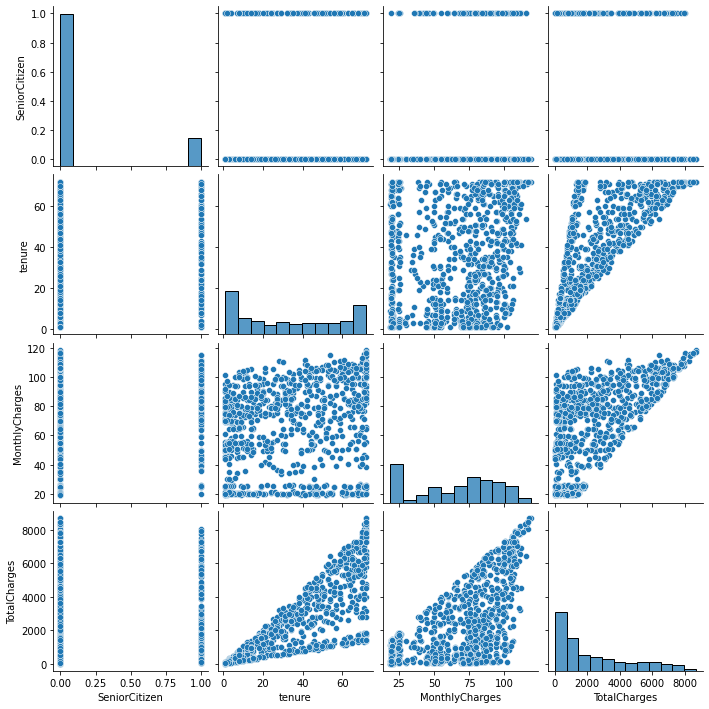

In [11]:
print('Test dataset Correlogram')
sns.pairplot(df_test.iloc[:,1:], kind="scatter")
plt.show()

We can observe that the variable SeniorCitizen has been identified as numeric because it has values 0 and 1 to categorize whether the citizen is a senior or not. However, we know that it is a category and not a continuous numeric variable. 

Let's see now how many customers have churn. 

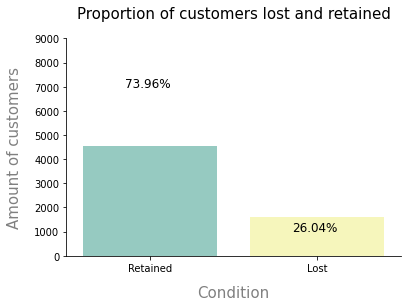

In [12]:
amount_retained = df_train[df_train['Churn'] == 'No']['Churn'].count() / df_train.shape[0] * 100
amount_lost = df_train[df_train['Churn'] == 'Yes']['Churn'].count() / df_train.shape[0] * 100

sns.countplot(x='Churn', palette="Set3", data=df_train)
plt.xticks([0, 1], ['Retained', 'Lost'])
plt.xlabel('Condition', size=15, labelpad=12, color='grey')
plt.ylabel('Amount of customers', size=15, labelpad=12, color='grey')
plt.title("Proportion of customers lost and retained", size=15, pad=20)
plt.ylim(0, 9000)
plt.text(-0.15, 7000, f"{round(amount_retained, 2)}%", fontsize=12)
plt.text(0.85, 1000, f"{round(amount_lost, 2)}%", fontsize=12)
sns.despine()

We can see that 26.04% of the customers have churned.

Now, let's analyze the relationship between categorical variables and the target variable

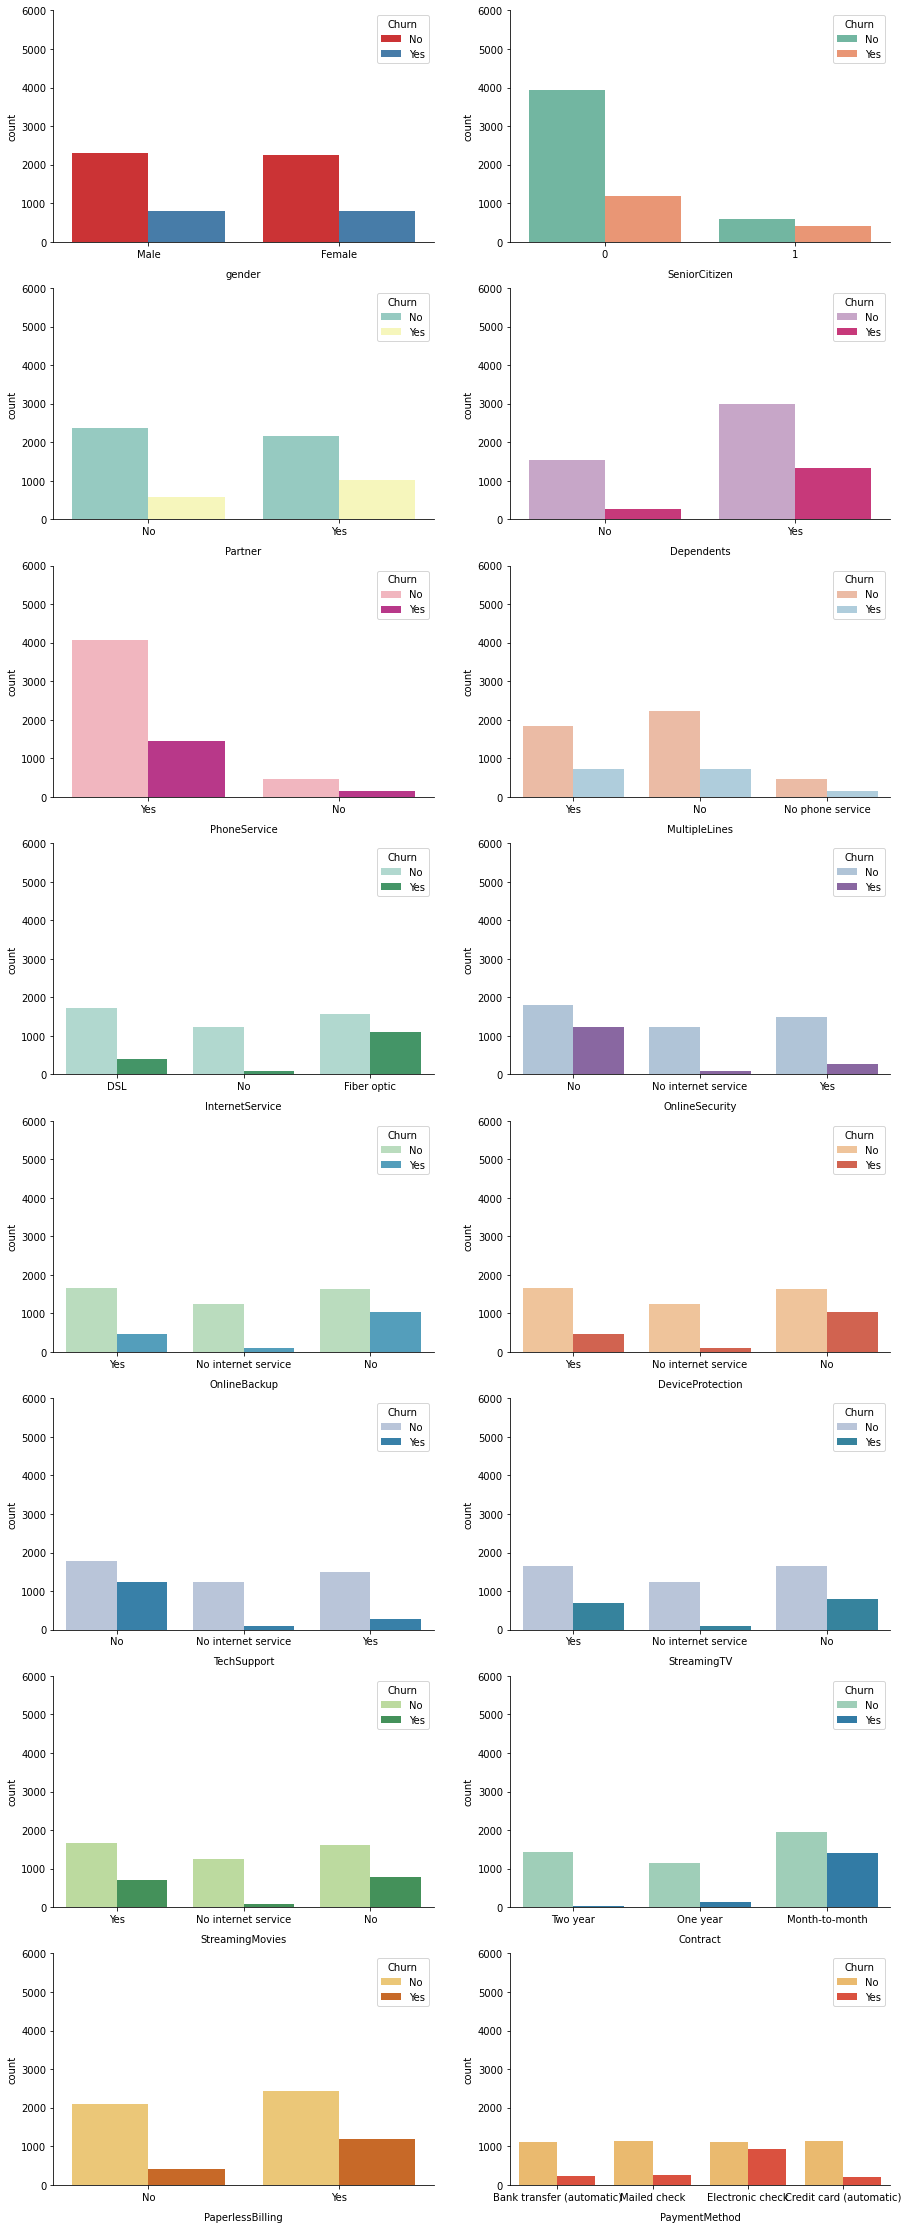

In [13]:
categorical_labels = [['gender', 'SeniorCitizen'], ['Partner', 'Dependents'], ['PhoneService', 'MultipleLines'], 
                      ['InternetService', 'OnlineSecurity'], ['OnlineBackup', 'DeviceProtection'], ['TechSupport', 'StreamingTV'], 
                      ['StreamingMovies', 'Contract'], ['PaperlessBilling', 'PaymentMethod']]
colors = [['Set1', 'Set2'], ['Set3', 'PuRd'], ['RdPu', 'RdBu'], ['BuGn', 'BuPu'], ['GnBu', 'OrRd'], ['PuBu', 'PuBuGn'],
          ['YlGn', 'YlGnBu'], ['YlOrBr', 'YlOrRd']]

fig, ax = plt.subplots(8, 2, figsize=(15, 40))
for i in range(8):
    for j in range(2):
        feature = categorical_labels[i][j]
        color = colors[i][j]
        ax1 = sns.countplot(x=feature, hue='Churn', palette=color, data=df_train, ax=ax[i][j])
        ax1.set_xlabel(feature, labelpad=10)
        ax1.set_ylim(0, 6000)
        ax1.legend(title='Churn', labels= ['No', 'Yes'])
        if i == 1:
            ax1.set_xticklabels(['No', 'Yes'])
sns.despine()

From the plots, we learn several things:

a. The proportion of female customers that churn is similar than the proportion of male customers.

b. Most of the customers are not senior citizens. 

c. Most of the customers who churn have a month-month contract, no technical support and no online security. 

Now, we can focus on the relationship between continuous variables and the target variable.

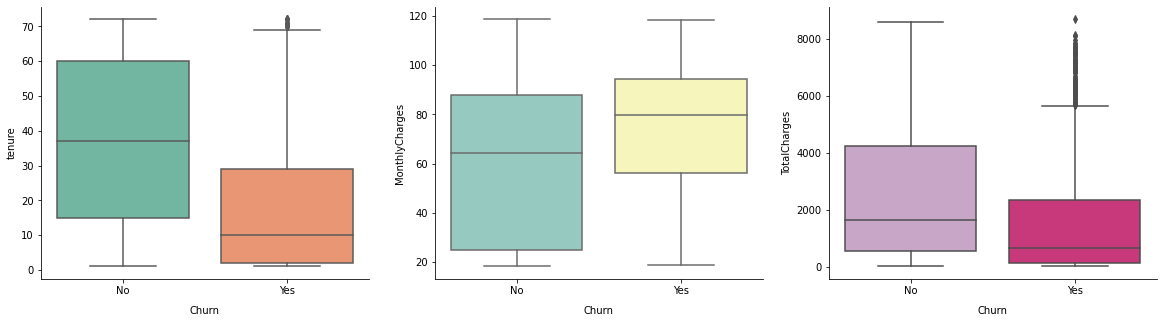

In [14]:
num_colors=[['Set2','Set3', 'PuRd']]
numerical_labels=[['tenure','MonthlyCharges', 'TotalCharges']]
fig, ax = plt.subplots(1, 3, figsize=(20, 5), squeeze=False)
for i in range(1):
    for j in range(3):
        feature = numerical_labels[i][j]
        color = num_colors[i][j]
        ax1 = sns.boxplot(x='Churn', y=feature, palette=color, data=df_train, ax=ax[i][j])
        ax1.set_xlabel('Churn', labelpad=10)
        ax1.set_xticklabels(['No', 'Yes'])
sns.despine()

From the plots, we learn several things:

a. Customers that churn have lower total charges. 

b. Customers that churn have higher monthly charges.

c. Customers that churn have been with the company for a shorter period of time.

# Export


We are going to export these clean datasets to import them into Google Drive and Google data Studio in order to create an interactive dashboard to view some metrics and graphs. 

In [15]:
#df_train.to_csv('Train_Set_New.csv', index=False) 

In [16]:
#df_test.to_csv('Test_Set_New.csv', index=False) 

# Model Predicting


Now, let's prepare the data to build some models to predict whether a customer will churn or not.

We’ll encode the categorical variables.

In [17]:
x_drop = ['customerID']

x = df_train.drop(x_drop, axis=1)

for label in ['gender', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 
              'InternetService', 'OnlineSecurity','OnlineBackup', 'DeviceProtection','TechSupport', 'StreamingTV', 
               'StreamingMovies', 'Contract','PaperlessBilling', 'PaymentMethod', 'Churn']:

    le = LabelEncoder()
    le.fit(x[label])
    print(le.classes_)
    x.loc[:, label] = le.transform(x[label])

y = x['Churn']
x_drop_2 = ['Churn']
x = x.drop(x_drop_2, axis=1)

['Female' 'Male']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'No phone service' 'Yes']
['DSL' 'Fiber optic' 'No']
['No' 'No internet service' 'Yes']
['No' 'No internet service' 'Yes']
['No' 'No internet service' 'Yes']
['No' 'No internet service' 'Yes']
['No' 'No internet service' 'Yes']
['No' 'No internet service' 'Yes']
['Month-to-month' 'One year' 'Two year']
['No' 'Yes']
['Bank transfer (automatic)' 'Credit card (automatic)' 'Electronic check'
 'Mailed check']
['No' 'Yes']


Let's do the same for our test dataset

In [18]:
x_test = df_test

for label in ['gender', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 
              'InternetService', 'OnlineSecurity','OnlineBackup', 'DeviceProtection','TechSupport', 'StreamingTV', 
               'StreamingMovies', 'Contract','PaperlessBilling', 'PaymentMethod']:

    le = LabelEncoder()
    le.fit(x_test[label])
    print(le.classes_)
    x_test.loc[:, label] = le.transform(x_test[label])

['Female' 'Male']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'No phone service' 'Yes']
['DSL' 'Fiber optic' 'No']
['No' 'No internet service' 'Yes']
['No' 'No internet service' 'Yes']
['No' 'No internet service' 'Yes']
['No' 'No internet service' 'Yes']
['No' 'No internet service' 'Yes']
['No' 'No internet service' 'Yes']
['Month-to-month' 'One year' 'Two year']
['No' 'Yes']
['Bank transfer (automatic)' 'Credit card (automatic)' 'Electronic check'
 'Mailed check']


We will split our training data into train and test to train models:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, 
                                                    shuffle=True, stratify=y)

Let's create some functions that will help getting the results easier

In [20]:
def print_best_model(model):
    """
    Prints the best parameteres, score and estimator for the model given.
    """
    print(f"The best parameters are: {model.best_params_}")
    print(f"The best model score is: {model.best_score_}")    
    print(f"The best estimator is: {model.best_estimator_}")
def get_scores(y, predicted, predicted_proba):
    """
    returns the roc auc scores for the given predictions
    """
    auc_score = roc_auc_score(y, predicted)
    fpr_df, tpr_df, _ = roc_curve(y, predicted_proba) 
    return auc_score, fpr_df, tpr_df
def get_confusion_matrix(y_test, y_predicted):
    plt.figure()
    random_confusion = confusion_matrix(y_test, y_predicted)
    ax = sns.heatmap(random_confusion, annot=True, cmap="YlGnBu");
    ax.set_ylim([0,2]);

Now, let's try some predictive models: 

## Logistic Regression

In [ ]:
param_grid_log = {
    'C': [0.1, 1, 10, 50, 100, 200],
    'max_iter': [200, 300],
    'penalty': ['l2'],
    'tol':[0.00001, 0.0001],
}
log_first = LogisticRegression(solver='lbfgs')
log_grid = GridSearchCV(log_first, param_grid=param_grid_log, cv=10, verbose=1, n_jobs=-2)
log_grid.fit(x, y)

In [23]:
print_best_model(log_grid)

The best parameters are: {'C': 200, 'max_iter': 200, 'penalty': 'l2', 'tol': 1e-05}
The best model score is: 0.805284259077214
The best estimator is: LogisticRegression(C=200, max_iter=200, tol=1e-05)


In [23]:
best_log_estimator = LogisticRegression(C=100, 
                                        max_iter=200, 
                                        penalty='l2', 
                                        tol=1e-05, 
                                        solver='lbfgs')

best_log_estimator.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=100, max_iter=200, tol=1e-05)

In [24]:
log_predict_test = best_log_estimator.predict(X_test)
accuracy_score(y_test, log_predict_test)
print(classification_report(y_test, log_predict_test))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       907
           1       0.69      0.54      0.61       320

    accuracy                           0.82      1227
   macro avg       0.77      0.73      0.74      1227
weighted avg       0.81      0.82      0.81      1227



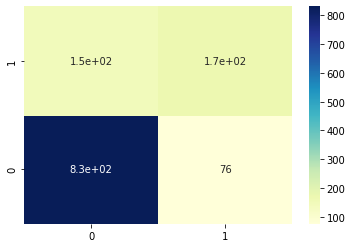

In [25]:
get_confusion_matrix(y_test, log_predict_test)

When we calculate the accuracy of the model, it comes out to be 82%. However, recall and f1-score are around 73% and there is a lot of false negatives, which is a situation we should avoid. In addition, there are not many true positives. 

## Support Vector Machines

In [ ]:
param_grid_svm = {
    'C': [0.5, 100, 150],
    'kernel': ['rbf'],
    'gamma': [0.1, 0.01, 0.001],
    'probability': [True]
}

svm_first = SVC()
svm_grid = GridSearchCV(svm_first, param_grid=param_grid_svm, cv=3, verbose=3, n_jobs=-2)
svm_grid.fit(x, y)
print_best_model(svm_grid)

In [27]:
best_svm_estimator = SVC(C=100, 
                         gamma=0.01, 
                         kernel='rbf', 
                         probability=True)

best_svm_estimator.fit(X_train, y_train)

SVC(C=100, gamma=0.01, probability=True)

In [28]:
svm_predict_test = best_svm_estimator.predict(X_test)
accuracy_score(y_test, svm_predict_test)
print(classification_report(y_test, svm_predict_test))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       907
           1       0.49      0.48      0.48       320

    accuracy                           0.73      1227
   macro avg       0.65      0.65      0.65      1227
weighted avg       0.73      0.73      0.73      1227



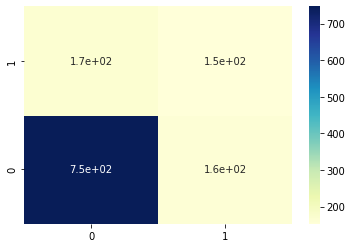

In [29]:
get_confusion_matrix(y_test, svm_predict_test)

When we calculate the accuracy of the model, it turns out to be 73%. The recall and f1 score have worsened from 73% to 65%. There are still many false negatives. However, there are more true positives. 

## Random Forest Classifier

In [ ]:
param_grid = {
              'max_depth': [3, 5, 6], 
              'max_features': [2, 4, 6],
              'n_estimators':[50, 100],
              'min_samples_split': [3, 5, 7]
             }
             
random_forest = RandomForestClassifier()
random_forest_grid = GridSearchCV(random_forest, param_grid, cv=5, refit=True, verbose=3, n_jobs=-2)
random_forest_grid.fit(x, y)
print_best_model(random_forest_grid)

In [31]:
best_rf_estimator = RandomForestClassifier(max_depth=6, 
                                           max_features=6, 
                                           min_samples_split=3, 
                                           n_estimators=100)

best_rf_estimator.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features=6, min_samples_split=3)

In [32]:
rf_predict_test = best_rf_estimator.predict(X_test)
accuracy_score(y_test, rf_predict_test)
print(classification_report(y_test, rf_predict_test))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       907
           1       0.73      0.46      0.56       320

    accuracy                           0.81      1227
   macro avg       0.78      0.70      0.72      1227
weighted avg       0.80      0.81      0.80      1227



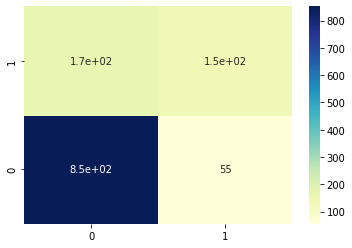

In [33]:
get_confusion_matrix(y_test, rf_predict_test)

When we calculate the accuracy of the model, it turns out to be 81%. The recall and f1 score have improved to around 70%. There are still many false negatives.

## Comparison of ROC Curves for the three models

We are going to investigate the False positive rates and true positive rates using ROC Curve and calculating the area under the curve that it is also a metric of the prediction power of our model.

If the value is closer to 1 means that our model does a good job in differentiating a random sample into the two classes.

In [36]:
auc_log, fpr_log, tpr_log = get_scores(y, best_log_estimator.predict(x), best_log_estimator.predict_proba(x)[:,1])
auc_svm, fpr_svm, tpr_svm = get_scores(y, best_svm_estimator.predict(x), best_svm_estimator.predict_proba(x)[:,1])
auc_rf, fpr_rf, tpr_rf = get_scores(y, best_rf_estimator.predict(x), best_rf_estimator.predict_proba(x)[:,1])

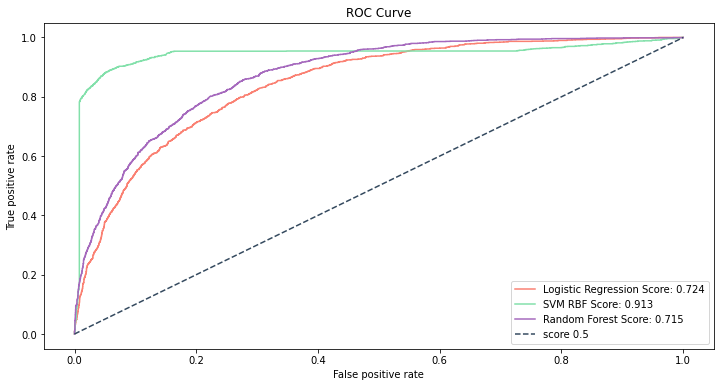

In [37]:
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_log, tpr_log, label = f'Logistic Regression Score: {str(round(auc_log, 3))}', color='#FA8072')
plt.plot(fpr_svm, tpr_svm, label = f'SVM RBF Score: {str(round(auc_svm, 3))}', color='#82E0AA')
plt.plot(fpr_rf, tpr_rf, label = f'Random Forest Score: {str(round(auc_rf, 3))}', color='#A569BD')
plt.plot([0,1], [0,1], '--', label = 'score 0.5', color='#34495E')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

Comparing the Area Under the Curve value for the three models, we see that SVM performs better than the other models.

## Feature Importance

We are going to analyze how the different features affect customer churn. For that, we are going to check the variable importance. That is to quantify how useful every variable is for our model.

This is an important analysis. We can identify what are the features that make a customer more likely to churn and plan targeted strategies.

However, for SVM is not possible to get the feature importance as the algorithm works like a black box.

### Logistic regression


In [46]:
features = x.columns
def get_most_important_features(model, num_features, model_type):
    selector = SelectFromModel(model, threshold=-np.inf, max_features=num_features)
    selector.fit(X_train, y_train)
    if model_type == "logistic":
        features_idx = selector.get_support()
        features_name = features[features_idx]
    else:
        return "It is not possible to get attributes"
    return features_name

get_most_important_features(model=best_log_estimator, num_features=4, model_type="logistic")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Index(['SeniorCitizen', 'PhoneService', 'Contract', 'PaperlessBilling'], dtype='object')

We can see that 'SeniorCitizen', 'PhoneService', 'Contract', and 'PaperlessBilling' are the most important features to predict if a customer will churn.

### Random Forest


In [44]:
def feature_importance(model, feature_list):
    """
    Function that gets and plots the feature importance
    for the given model
    :param model: the model to evaluaate
    :param feature_list: a list of features contained in the model
    :returns a plot with feature importance
    """
    #Get the list of feaature importance from the model
    importances = list(model.feature_importances_)
    #zip together feature names and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    #sort the feature importance by importance
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    #Print the list of feature importance
    [print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances];
    #set colors for the plot
    colors = cm.rainbow(np.linspace(0, 1, len(feature_list)))
    
    #get the list of features sorted
    characteristics = [x[0] for x in feature_importances]
    #get the list of importance sorted
    importances_plot = [x[1] for x in feature_importances]
    #plot in a bar plot
    plt.bar(characteristics, importances_plot, color=colors)
    #adjust characteristics of the plot
    plt.xticks(list(range(len(characteristics))), characteristics, rotation = 90)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gcf().subplots_adjust(bottom=0.3);

Variable: Contract Importance: 0.23
Variable: tenure Importance: 0.18
Variable: OnlineSecurity Importance: 0.13
Variable: MonthlyCharges Importance: 0.11
Variable: TotalCharges Importance: 0.11
Variable: TechSupport Importance: 0.07
Variable: InternetService Importance: 0.05
Variable: OnlineBackup Importance: 0.03
Variable: PaperlessBilling Importance: 0.02
Variable: PaymentMethod Importance: 0.02
Variable: SeniorCitizen Importance: 0.01
Variable: MultipleLines Importance: 0.01
Variable: DeviceProtection Importance: 0.01
Variable: StreamingTV Importance: 0.01
Variable: StreamingMovies Importance: 0.01
Variable: gender Importance: 0.0
Variable: Partner Importance: 0.0
Variable: Dependents Importance: 0.0
Variable: PhoneService Importance: 0.0


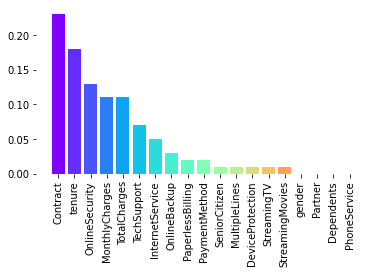

In [45]:
feature_importance(best_rf_estimator, features)

It appears that contract is an important variable common to both models. 

## Final Comparison

Now let's predict using Random Forest and compare with the actual results:

In [66]:
#Random Forest
predictions=best_rf_estimator.predict(x_test.iloc[:,1:])
pred=[]
for i in range(len(predictions)):
  pred.append(predictions[i])

#Logistic Regression 
predictions_2=best_log_estimator.predict(x_test.iloc[:,1:])
pred_2=[]
for i in range(len(predictions)):
  pred_2.append(predictions_2[i])

#Logistic SVM
predictions_3=best_svm_estimator.predict(x_test.iloc[:,1:])
pred_3=[]
for i in range(len(predictions)):
  pred_3.append(predictions_3[i])

In [67]:
df_comp = pd.DataFrame(list(zip(list(y[0:900]), pred, pred_2, pred_3)),
               columns =['Actual', 'Random Forest', 'Logistic Regression', 'SVM'])

In [69]:
print('Customers who actual churned: ', len(df_comp[df_comp['Actual']==1]))
print('Customers who churned based on Random Forest: ', len(df_comp[df_comp['Random Forest']==1]))
print('Customers who churned based on Logistic Regression: ', len(df_comp[df_comp['Logistic Regression']==1]))
print('Customers who churned based on SVM: ', len(df_comp[df_comp['SVM']==1]))

Customers who actual churned:  239
Customers who churned based on Random Forest:  173
Customers who churned based on Logistic Regression:  215
Customers who churned based on SVM:  222
